In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data, log, load_csv, save_csv, calculate_season_average_until_gw
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
import xgboost as xgb
from itertools import combinations
from sklearn.metrics import root_mean_squared_error, r2_score

In [2]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["MID"]
output_file_name = "mid_training_data.csv"

log("Combining position data...", level="INFO")
combine_position_data(data_directory, seasons, positions, output_file_name)

INFO: Combining position data...
INFO: Loaded data from MID_players.csv for season 2022-23.
INFO: Loaded data from MID_players.csv for season 2023-24.
INFO: Loaded data from MID_players.csv for season 2024-25.
INFO: Combined data saved to Fantasy-Premier-League/data/training_data/mid_training_data.csv.


RMSE: 1.8934
R²: 0.4099


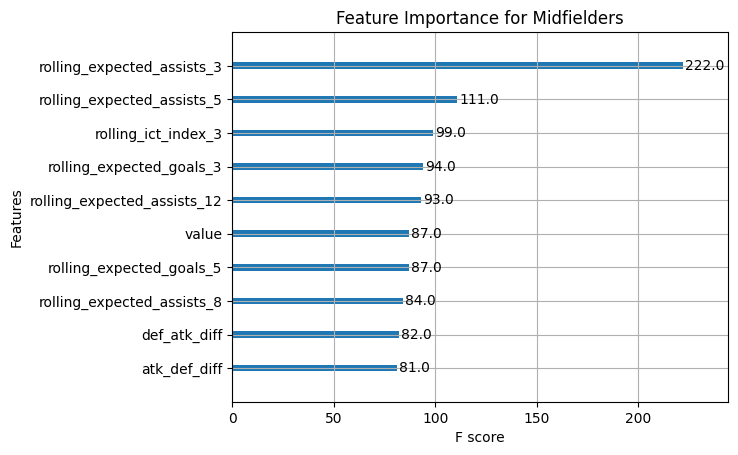

INFO: Model saved at: models/mid_prediction_model.json


In [66]:
training_data_dir = os.path.join(data_directory, "training_data")
training_file = os.path.join(training_data_dir, output_file_name)
mid_data = load_csv(training_file)
if mid_data is None:
    log("Failed to load training data. Exiting.", level="ERROR")
    exit()

# ========================
# Feature Engineering
# ========================
mid_data['was_home'] = mid_data['was_home'].astype(int)
mid_data["def_atk_diff"] = mid_data["own_defense"]-mid_data["opponent_attack"]
mid_data["atk_def_diff"] = mid_data["own_attack"]-mid_data["opponent_defense"]
mid_data = mid_data.sort_values(by=["unique_id", "season", "gameweek"]).reset_index(drop=True)

rolling_periods = [3, 5, 8, 12]
base_features = ["expected_assists", "expected_goals", "ict_index", "team_deep", "shots", "key_passes"]

for period in rolling_periods:
    for feature in base_features:
        if feature =="team_deep":
            mid_data[f"rolling_{feature}_{period}"] = (
                mid_data.groupby("unique_id")[feature]
                .shift(1)
                .rolling(window=period, min_periods=1)
                .mean()
            )
        else:
            mid_data[f"rolling_{feature}_{period}"] = (
                mid_data[mid_data["minutes"] > 0]
                .groupby("unique_id")[feature]
                .shift(1)
                .rolling(window=period, min_periods=1)
                .mean()
                .reindex(mid_data.index, fill_value=0)
            )

mid_data["avg_yellow_cards"] = (
    mid_data[mid_data["minutes"] > 0]
    .groupby("unique_id")["yellow_cards"]
    .shift(1)
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)


dummy_columns = ["was_home", "penalties_order", "unique_id"]
mid_data = pd.get_dummies(mid_data, columns=dummy_columns)
# Final Feature Set
rolling_features = [f"rolling_{feature}_{period}" for feature in base_features for period in rolling_periods]
additional_features = ["def_atk_diff", "value", "atk_def_diff", "avg_yellow_cards"]
numerical_features = rolling_features + additional_features
categorical_features = [
    col for col in mid_data.columns if any(col.startswith(f"{dummy_col}_") for dummy_col in dummy_columns)
]
features = numerical_features + categorical_features
target = "total_points"

# ========================
# Train-Test Split
# ========================
X = mid_data[features]
y = mid_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Feature Importance Plot
xgb.plot_importance(model, max_num_features=10)
plt.title("Feature Importance for Midfielders")
plt.show()

# Save Model
# ========================
models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "mid_prediction_model.json")
model.save_model(model_path)
log(f"Model saved at: {model_path}", level="INFO")

# ========================
# Optional Hyperparameter Tuning
# ========================
def hyperparameter_tuning(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    log("Starting hyperparameter tuning...", level="INFO")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    model = XGBRegressor(random_stateexpected_goals_conceded=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    log(f"Best parameters found: {grid_search.best_params_}", level="INFO")
    log(f"Best RMSE: {-grid_search.best_score_}", level="INFO")
    return grid_search.best_estimator_

# Uncomment to perform tuning
# best_model = hyperparameter_tuning(X_train, y_train)